In [1]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
import os   

In [2]:
from dotenv import load_dotenv

In [3]:
load_dotenv()

True

## Loading the model

In [4]:
from langchain_groq import ChatGroq
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b",api_key=os.getenv("GROQ_API_KEY"))

In [ ]:
groq_model.invoke("hi").content

APIConnectionError: Connection error.

In [ ]:
def clean_text(text):
    import re
    clean_text = re.sub(r"<think>.*?</think>\s*", "", text, flags=re.DOTALL)
    return clean_text

In [ ]:
response=groq_model.invoke("hi")

In [ ]:
response.content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [ ]:
clean_text(response.content)

'Hello! How can I assist you today? 😊'

In [ ]:
tavaily_tool=TavilySearchResults()

C:\Users\91827\AppData\Local\Temp\ipykernel_17984\820692609.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavaily_tool=TavilySearchResults()


In [ ]:
tavaily_tool.invoke("what is a gdp?")

[{'title': 'Gross domestic product - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Gross_domestic_product',
  'content': 'Gross domestic product (GDP) is a monetarymeasure of the total market value( of all the final goods and services produced and rendered in a specific time period by a country( or countries.( GDP is often used to measure the economic performance of a country or region.( Several national and international economic organizations maintain definitions of GDP, such as the OECD and the International Monetary Fund.( [...] GDP (Y) is the sum of consumption (C), investment (I), government expenditures (G) and net exports (X − M).\n\nY = C + I + G + (X − M)\nHere is a description of each GDP component: [...] Sustainability of growth – GDP is a measurement of economic historic activity and is not necessarily a projection.\n   Income distribution – GDP does not account for variances in incomes of various demographic groups. See income inequality metrics for discussion of a 

In [ ]:
code = """
x = 5
y = x * 2
print(y)
"""

In [ ]:
repl=PythonREPL()

In [ ]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [ ]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
C:\Users\91827\AppData\Local\Temp\ipykernel_17984\3901756031.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\91827\AppData\Local\Temp\ipykernel_17984\3901756031.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [ ]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10



In [ ]:
members=["researcher","coder"]

In [ ]:
options=members+["FINISH"]

In [ ]:
options

['researcher', 'coder', 'FINISH']

In [ ]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal['researcher', 'coder', 'FINISH']

In [ ]:
class State(MessagesState):
    next:str

In [ ]:
system_prompt=f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [ ]:
[{"role": "system", "content": system_prompt},]

[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n"}]

In [ ]:
state={"next":["hi"]}

In [ ]:
state["next"]

['hi']

In [ ]:
[{"role": "system", "content": system_prompt},] + state["next"]

[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n"},
 'hi']

In [ ]:
def supervisor_node(state: State) -> Command[Literal["researcher", "coder", "__end__"]]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    response = groq_model.with_structured_output(Router).invoke(messages)
    
    goto = response["next"]
    
    print("below my goto**********************************")
    
    print(goto)
    
    if goto == "FINISH":
        goto = END
        
    return Command(goto=goto, update={"next": goto})

In [ ]:
def research_node(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(groq_model, tools=[tavaily_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result = research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [ ]:
def code_node(state: State) -> Command[Literal["supervisor"]]:
    
    code_agent = create_react_agent(groq_model, tools=[python_repl_tool])
    
    result = code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


In [ ]:
graph=StateGraph(State)

In [ ]:
graph.add_node("supervisor",supervisor_node)

In [ ]:
graph.add_node("researcher", research_node)

In [ ]:
graph.add_node("coder", code_node)

In [ ]:
graph.add_edge(START,"supervisor")


In [ ]:
app=graph.compile()

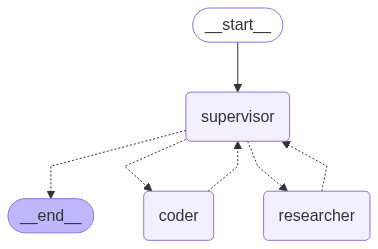

In [ ]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# With the graph created, we can now invoke it and see how it performs!
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("----")

below my goto**********************************
coder
((), {'supervisor': {'next': 'coder'}})
----
(('coder:d8836fbd-4877-fb09-ec99-8d45b78e2f90',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5ebacrt20', 'function': {'arguments': '{"code":"import math\\nprint(math.sqrt(42))"}', 'name': 'python_repl_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 282, 'prompt_tokens': 179, 'total_tokens': 461, 'completion_time': 1.358010144, 'prompt_time': 0.011424189, 'queue_time': 0.058133804, 'total_time': 1.369434333}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b76e1ac4-68d5-4cc0-bd26-9a0ef15868a9-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nprint(math.sqrt(42))'}, 'id': '5ebacrt20', 'type': 'tool_call'}], usage_metadata={'input_tokens': 179, 'output_tokens': 282, 'total_tokens': 461})]

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
app.invoke({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True)

below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
FINISH


((),
 {'messages': [HumanMessage(content="What's the square root of 42?", additional_kwargs={}, response_metadata={}, id='094973c8-591b-499c-8a3d-e8f5d94b3984'),
   HumanMessage(content='The square root of 42 is approximately 6.4807.', additional_kwargs={}, response_metadata={}, name='researcher', id='22cfec39-cf47-4d96-b834-fd9d78389866'),
   HumanMessage(content='The square root of 42 is approximately 6.4807. This is an irrational number, meaning it cannot be expressed exactly as a simple fraction and its decimal representation is non-repeating and infinite.', additional_kwargs={}, response_metadata={}, name='researcher', id='9e1e6f5b-d324-42e7-a61f-b4e121808bc0'),
   HumanMessage(content="\n\nOkay, so I need to figure out the square root of 42. Hmm, I remember that the square root of a number is a value that, when multiplied by itself, gives the original number. So, I'm looking for a number that, when I square it, equals 42.\n\nFirst, I'll think about perfect squares near 42 to get 

In [ ]:
app.invoke({"messages": [("user", "What is an efficient Python code to get prime numbers?")]}, subgraphs=True)

below my goto**********************************
coder
below my goto**********************************
coder
below my goto**********************************
FINISH


((),
 {'messages': [HumanMessage(content='What is an efficient Python code to get prime numbers?', additional_kwargs={}, response_metadata={}, id='3ea6d4d1-bf79-4962-aeb7-b4ab9d61236b'),
   HumanMessage(content='To efficiently find prime numbers using Python, the Sieve of Eratosthenes algorithm is a highly effective method. Here\'s an implementation of the Sieve of Eratosthenes:\n\n<tool_call>{"name": "python_repl_tool", "arguments": {"code": "def sieve_of_eratosthenes(n):\\n    if n < 2:\\n        return []\\n    prime = [True] * (n + 1)\\n    prime[0], prime[1] = False, False\\n    for i in range(2, int(n ** 0.5) + 1):\\n        if prime[i]:\\n            for j in range(i*i, n+1, i):\\n                prime[j] = False\\n    primes = [i for i, is_prime in enumerate(prime) if is_prime]\\n    return primes\\n\\nprint(sieve_of_eratosthenes(20))"}}', additional_kwargs={}, response_metadata={}, name='coder', id='301bd894-8096-4ab7-87b8-e4796f363704'),
   HumanMessage(content="The Sieve of 